In [11]:
import json
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint as pp
import pandas as pd
import seaborn as sns
from time import sleep


In [30]:
exp_dir = './ga'
log = {}
with open(f'{exp_dir}/log.json', 'r') as f:
    log = json.load(f)

In [34]:
baseline = np.zeros(len(log['average_scores']))

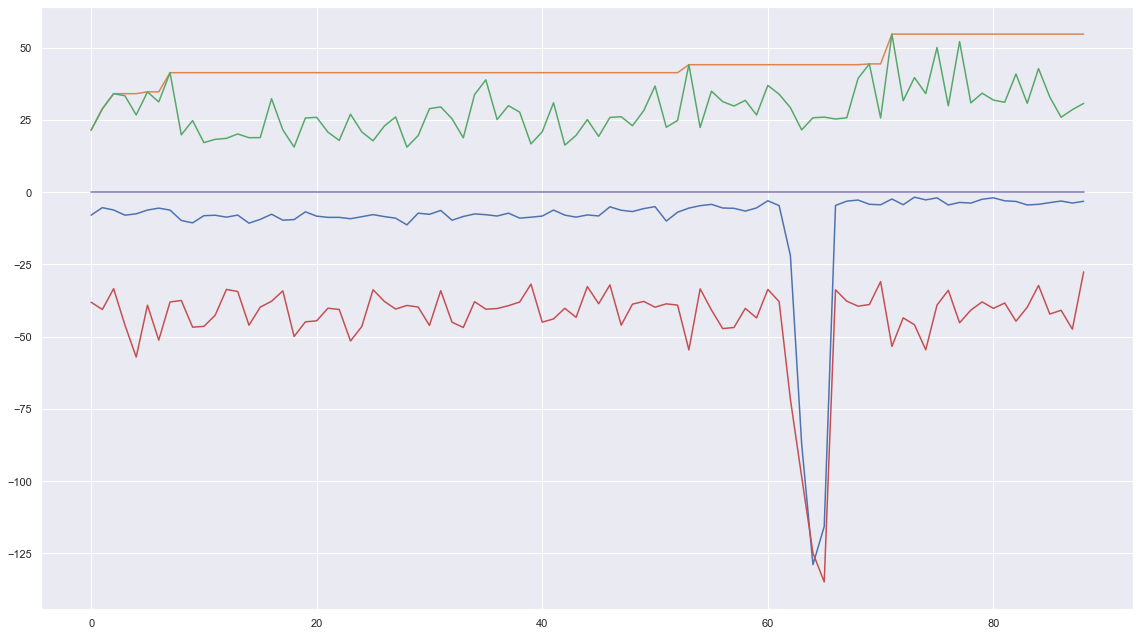

In [35]:
plt.plot(log['average_scores'])
plt.plot(log['king_scores'])
plt.plot(log['gen_maxes'])
mins = np.array(log['gen_maxes']) - np.array(log['score_ranges'])
plt.plot(mins)
plt.plot(baseline)

Best Average Score: -1.7435351575101214 at Generation 74
Best Gen Max: 54.65999999999971 at Generation 72


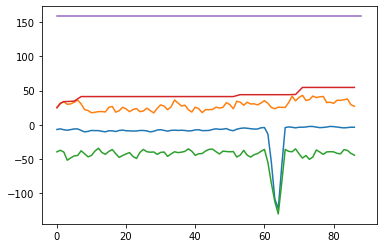

In [15]:
running_average = []
starting_cutoff = 0
look_back = 2
for idx in range(starting_cutoff, len(log['average_scores'])-look_back):
    running_average.append(np.mean(log['average_scores'][idx:idx+look_back]))
plt.plot(running_average)
running_average = []
for idx in range(starting_cutoff, len(log['gen_maxes'])-look_back):
    running_average.append(np.mean(log['gen_maxes'][idx:idx+look_back]))
plt.plot(running_average)
running_average = []
for idx in range(starting_cutoff, len(mins)-look_back):
    running_average.append(np.mean(mins[idx:idx+look_back]))
plt.plot(running_average)
running_average = []
for idx in range(starting_cutoff, len(log['king_scores'])-look_back):
    running_average.append(np.mean(log['king_scores'][idx:idx+look_back]))
plt.plot(running_average)

plt.plot(baseline)

print(f'Best Average Score: {np.max(log["average_scores"])} at Generation {np.argmax(log["average_scores"]) + 1}')
print(f'Best Gen Max: {np.max(log["gen_maxes"])} at Generation {np.argmax(log["gen_maxes"]) + 1}')

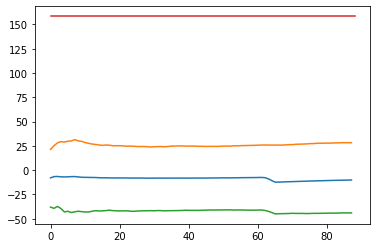

In [16]:
cum_avg = []
for idx in range(len(log['average_scores']) - 1):
    cum_avg.append(np.mean(log['average_scores'][:idx+1]))
plt.plot(cum_avg)
cum_avg = []
for idx in range(len(log['gen_maxes']) - 1):
    cum_avg.append(np.mean(log['gen_maxes'][:idx+1]))
plt.plot(cum_avg)
cum_avg = []
for idx in range(len(mins) - 1):
    cum_avg.append(np.mean(mins[:idx+1]))
plt.plot(cum_avg)
plt.plot(baseline)

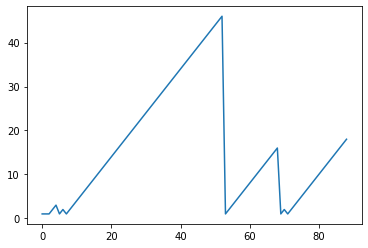

In [17]:
streaks = []
current_score = 0
current_streak = 0
streaks_non_consecutive = []
for score in log['king_scores']:
    if score == current_score:
        current_streak += 1
    elif score > current_score:
        current_score = score
        current_streak = 1
    streaks.append(current_streak)
plt.plot(streaks)

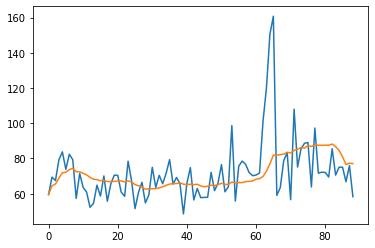

In [18]:
plt.plot(log['score_ranges'])
smoothed_ranges = []
for idx in range(0, len(log['score_ranges'])):
    smoothed_ranges.append(np.mean(log['score_ranges'][max(0, idx-20):idx+1]))
plt.plot(smoothed_ranges)

In [19]:
def pad_generation(gen_num: int) -> str:
    if gen_num < 10:
        return '00' + str(gen_num)
    elif gen_num < 100:
        return '0' + str(gen_num)
    return str(gen_num)

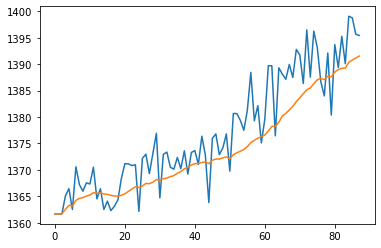

In [22]:
current_gen = log['generation']
trained_net = None
trained_net = {
    "weights": np.zeros((22,8)),
    "biases": np.zeros((1, 8)),
}
sum_diffs = []
ss_diffs = []
weight_2_3 = []
all_kings = []
for idx in range(1, current_gen - 1):
    ga_net = None
    with open(f'{exp_dir}/' + pad_generation(idx) + '-00.xpainet', 'rb') as f:
        ga_net = pickle.load(f)
    all_kings.append(ga_net)
    weight_2_3.append(np.array(ga_net['weights'])[3][2])
    weight_diff = np.array(ga_net['weights']) - np.array(trained_net['weights'])
    weight_diff = np.abs(weight_diff)
    bias_diff = np.array(ga_net['biases']) - np.array(trained_net['biases'])
    bias_diff = np.abs(bias_diff)
    sum_diff = np.sum(weight_diff) + np.sum(bias_diff)
    ss_diff = np.sum(weight_diff**2) + np.sum(bias_diff**2)
    sum_diffs.append(sum_diff)
    ss_diffs.append(ss_diff)
##plt.plot(weight_2_3)
plt.plot(sum_diffs)
##plt.plot(ss_diffs)\

smoothed_ranges = []
for idx in range(0, len(sum_diffs)):
    smoothed_ranges.append(np.mean(sum_diffs[max(0, idx-20):idx+1]))
plt.plot(smoothed_ranges)

<AxesSubplot:>

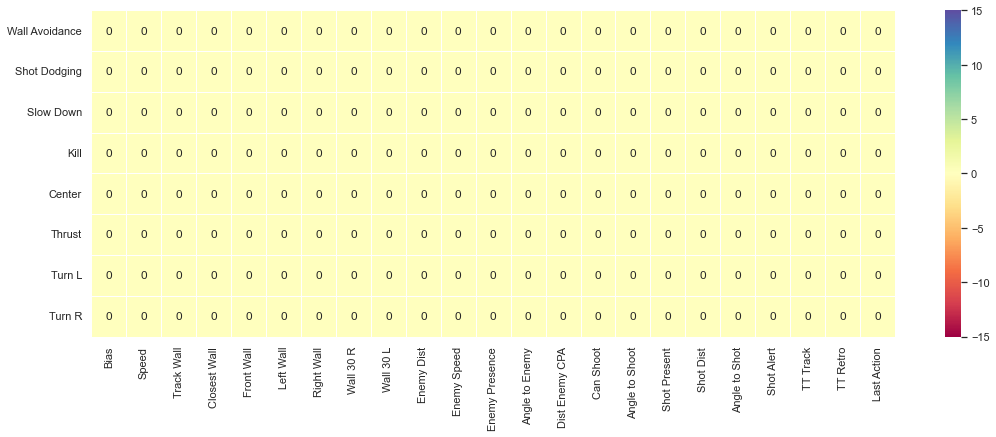

In [23]:
sns.set_theme()
def network_to_dataframe(net: dict) -> pd.DataFrame:
    weights = np.array(net['weights'])
    weights = np.transpose(weights)
    import pandas as pd
    df = pd.DataFrame(weights)
    df.columns = ['Speed', 'Track Wall', 'Closest Wall', 'Front Wall', 'Left Wall', 'Right Wall', 'Wall 30 R', 'Wall 30 L', 'Enemy Dist', 'Enemy Speed', 'Enemy Presence', 'Angle to Enemy', 'Dist Enemy CPA', 'Can Shoot', 'Angle to Shoot', 'Shot Present', 'Shot Dist', 'Angle to Shot', 'Shot Alert', 'TT Track', 'TT Retro', 'Last Action']
    df.insert(0, 'Bias', net['biases'][0], allow_duplicates=False)
    df.index = ['Wall Avoidance', 'Shot Dodging', 'Slow Down', 'Kill', 'Center', 'Thrust', 'Turn L', 'Turn R']
    return df
trained_net_df = network_to_dataframe(trained_net)
##df.pivot(index='Observation', columns='Action')
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(trained_net_df, annot=True, linewidths=1, ax=ax, vmin=-15, vmax=15, cmap="Spectral")

<AxesSubplot:>

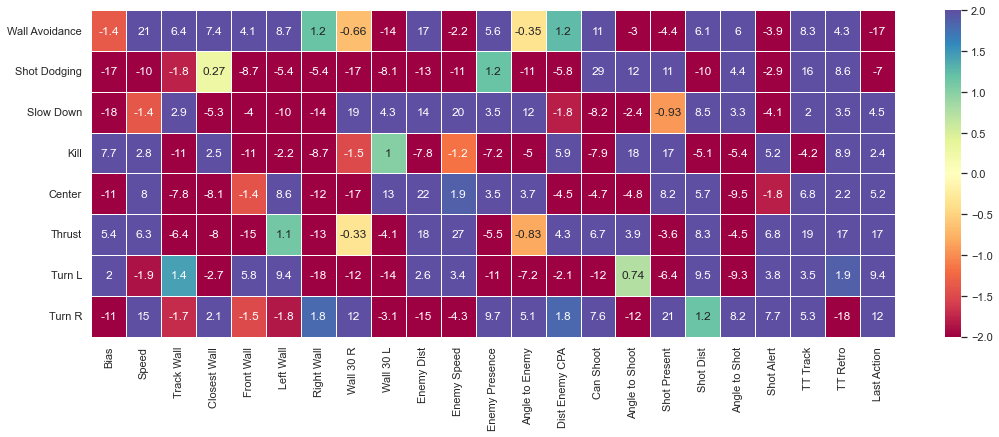

In [27]:
latest_winner = []
with open(f'{exp_dir}/' + pad_generation(current_gen - 20) + '-00.xpainet', 'rb') as f:
    latest_winner = pickle.load(f)
previous_winner = []
with open(f'{exp_dir}/' + pad_generation(current_gen - 1) + '-00.xpainet', 'rb') as f:
    previous_winner = pickle.load(f)
diff_net = {
    'weights': np.array(latest_winner['weights']) - np.array(trained_net['weights']),
    'biases': np.array(latest_winner['biases']) - np.array(trained_net['biases'])
}
diff_net_df = network_to_dataframe(diff_net)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(diff_net_df, annot=True, linewidths=1, ax=ax, vmax=2, vmin=-2, center=0, cmap="Spectral")

<AxesSubplot:>

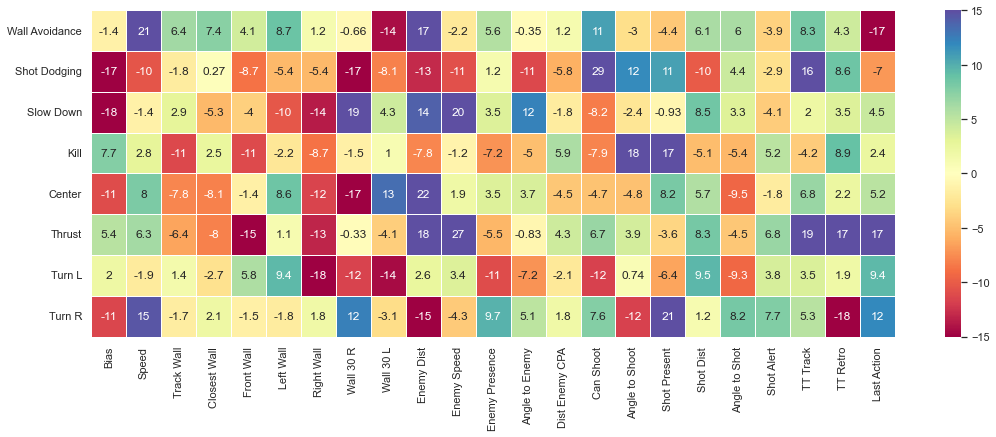

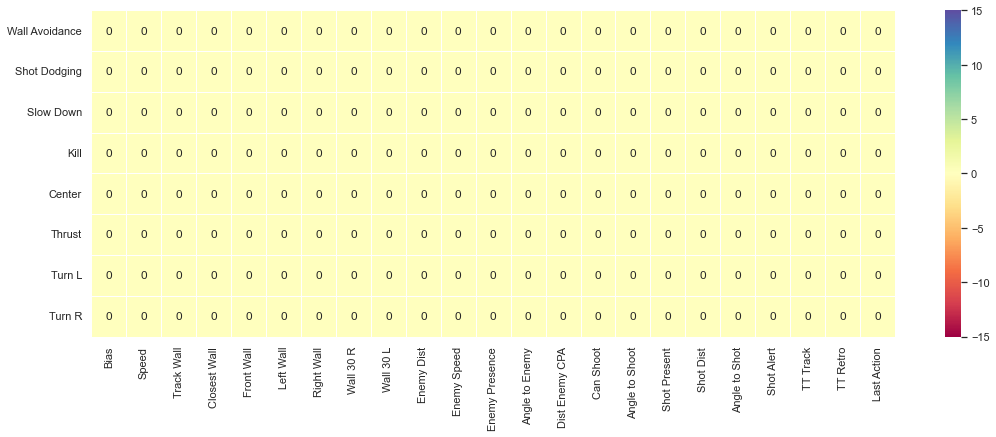

In [28]:
latest_winner_df = network_to_dataframe(latest_winner)

f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(latest_winner_df, annot=True, linewidths=1, ax=ax, vmin=-15, vmax=15, cmap="Spectral")
sleep(5)
f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(trained_net_df, annot=True, linewidths=1, ax=ax, vmin=-15, vmax=15, cmap="Spectral")

MovieWriter w+b unavailable; using Pillow instead.


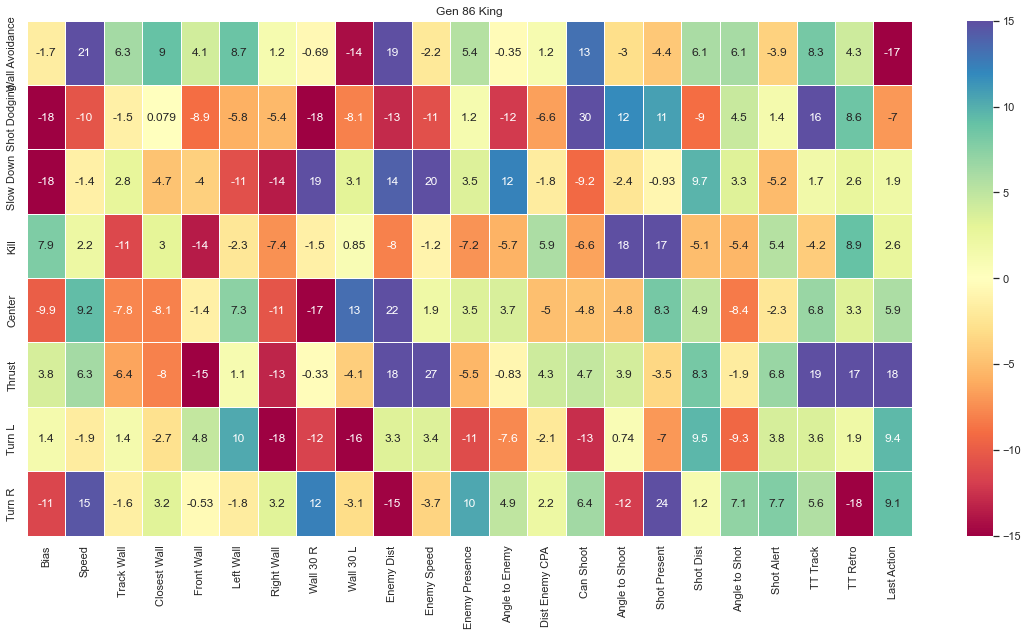

In [29]:
from celluloid import Camera
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
dimension = (5, 16)


sns.heatmap(trained_net_df, annot=True, linewidths=.5, vmin=-15, vmax=15, cmap="Spectral")
current_king_df = network_to_dataframe(all_kings[0])
def init():
    sns.heatmap(current_king_df, annot=True, linewidths=1, vmin=-15, vmax=15, cmap="Spectral")

def animate(i):
    fig.clf()
    current_king_df = network_to_dataframe(all_kings[i])
    sns.heatmap(current_king_df, annot=True, linewidths=1, vmin=-15, vmax=15, cmap="Spectral").set(title=f'Gen {i} King')

anim = FuncAnimation(fig, animate, init_func=init, frames=len(all_kings) - 1, repeat=False, interval=33)
anim.save('ga_0_90.gif', 'w+b',)

In [ ]:
from math import cos, sin, atan

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, weights):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = neuron_radius * sin(angle)
        y_adjustment = neuron_radius * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        line = plt.Line2D(line_x_data, line_y_data, linewidth=linewidth)
        plt.gca().add_line(line)

    def draw(self):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw()
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[this_layer_neuron_index, previous_layer_neuron_index]
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)


class NeuralNetwork():
    def __init__(self):
        self.layers = []

    def add_layer(self, number_of_neurons, weights=None):
        layer = Layer(self, number_of_neurons, weights)
        self.layers.append(layer)

    def draw(self):
        for layer in self.layers:
            layer.draw()
        plt.axis('scaled')
        plt.show()


if __name__ == "__main__":
    vertical_distance_between_layers = 6
    horizontal_distance_between_neurons = 2
    neuron_radius = 0.5
    number_of_neurons_in_widest_layer = 4
    network = NeuralNetwork()
    # weights to convert from 10 outputs to 4 (decimal digits to their binary representation)
    weights1 = np.array([\
                         [0,0,0,0,0,0,0,0,1,1],\
                         [0,0,0,0,1,1,1,1,0,0],\
                         [0,0,1,1,0,0,1,1,0,0],\
                         [0,1,0,1,0,1,0,1,0,1]])
    network.add_layer(10, weights1)
    network.add_layer(4)
    network.draw()